对风电进行预测

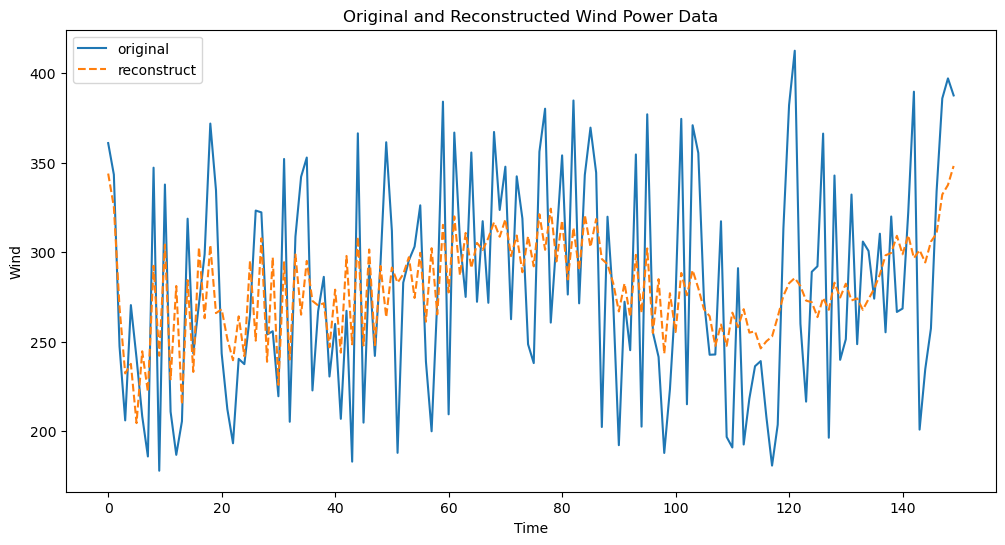

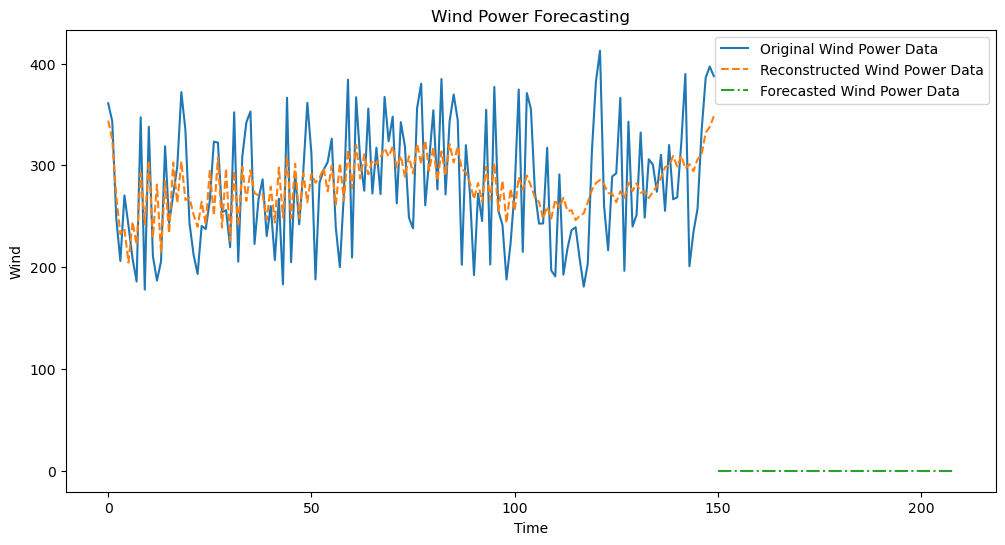

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import hankel, svd
from sklearn.linear_model import LinearRegression

# 生成示例数据
np.random.seed(0)
data_size = 150
wind_speed = np.random.rand(data_size) * 10  # 风速 (0-10 m/s)
temperature = np.random.rand(data_size) * 30  # 温度 (0-30 °C)
pressure = np.random.rand(data_size) * 1000 + 900  # 气压 (900-1900 hPa)

# 假设风电与风速、温度和气压有关
wind_power = (
    0.5 * wind_speed
    + 0.3 * temperature
    + 0.2 * pressure
    + np.random.randn(data_size) * 10
)

# 创建数据序列
wind_power_series = wind_power

# SSA参数
L = 40  # 窗口长度（嵌入维度）
K = len(wind_power_series) - L + 1  # 轨迹矩阵的列数

# 构建轨迹矩阵（Hankel矩阵）
X = hankel(wind_power_series[:L], wind_power_series[L - 1 :])

# SVD分解
U, s, VT = svd(X)
d = np.linalg.matrix_rank(X)

# 选择前r个主成分
r = 5  # 可以根据需要调整
U_r = U[:, :r]
s_r = s[:r]
VT_r = VT[:r, :]
X_r = np.dot(U_r, np.dot(np.diag(s_r), VT_r))

# 重构时间序列
reconstructed_series = np.zeros(len(wind_power_series))
counts = np.zeros(len(wind_power_series))

for i in range(L):
    reconstructed_series[i : i + K] += X_r[i, :]
    counts[i : i + K] += 1

reconstructed_series /= counts

# 可视化原始和重构的时间序列
plt.figure(figsize=(12, 6))
plt.plot(wind_power_series, label="original")
plt.plot(reconstructed_series, label="reconstruct", linestyle="--")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Wind")
plt.title("Original and Reconstructed Wind Power Data")
plt.show()

# 预测未来数据
forecast_horizon = 20  # 预测步长
forecast_PCs = np.zeros((r, forecast_horizon))

for comp in range(r):
    # 获取主成分的时间序列
    PC_series = s_r[comp] * VT_r[comp, :]

    # 使用自回归模型进行预测
    L_PC = L  # 主成分的窗口长度，可以与L相同
    X_train = np.array(
        [PC_series[i : i + L_PC] for i in range(len(PC_series) - L_PC)]
    )
    y_train = PC_series[L_PC:]

    # 检查是否有足够的数据进行训练
    if len(X_train) == 0:
        continue

    model = LinearRegression()
    model.fit(X_train, y_train)

    # 准备预测数据
    last_window = PC_series[-L_PC:]

    preds = []
    for _ in range(forecast_horizon):
        pred = model.predict(last_window.reshape(1, -1))
        preds.append(pred[0])
        last_window = np.roll(last_window, -1)
        last_window[-1] = pred

    # 收集每个主成分的预测结果
    forecast_PCs[comp, :] = preds

# 将预测的主成分叠加，得到预测的轨迹矩阵
forecast_X = np.dot(U_r[:, :r], forecast_PCs)

# 重构预测的时间序列
forecast_series = np.zeros(forecast_horizon + L - 1)
counts_forecast = np.zeros(forecast_horizon + L - 1)

for i in range(L):
    forecast_series[i : i + forecast_horizon] += forecast_X[i, :]
    counts_forecast[i : i + forecast_horizon] += 1

forecast_series /= counts_forecast

# 合并历史数据和预测数据
total_series = np.concatenate((wind_power_series, forecast_series))
time_axis = np.arange(len(total_series))

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(
    time_axis[: len(wind_power_series)],
    wind_power_series,
    label="Original Wind Power Data",
)
plt.plot(
    time_axis[: len(wind_power_series)],
    reconstructed_series,
    label="Reconstructed Wind Power Data",
    linestyle="--",
)
plt.plot(
    time_axis[len(wind_power_series) :],
    forecast_series,
    label="Forecasted Wind Power Data",
    linestyle="-.",
)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Wind")
plt.title("Wind Power Forecasting")
plt.show()

太阳能预测


Mean Squared Error: 3028.244202066281
        Actual   Predicted
26  118.419620  114.450647
86  359.490537  431.470349
2   453.396914  467.145082
55  183.031171  124.795826
75  110.405872  -17.470729
93  570.524749  555.157590
16   11.455016  -13.224045
73  497.645447  469.486526
54  157.551053  221.457756
95  106.743690  123.877410
53  183.579412   63.647908
92   98.991153  105.061822
78  269.896730  236.999643
13  774.195848  726.109364
7   734.241426  677.602809
30  176.566974  252.873850
22  330.971901  347.030949
24  121.440025   97.483371
33  486.330944  481.009180
8   711.330517  752.727730


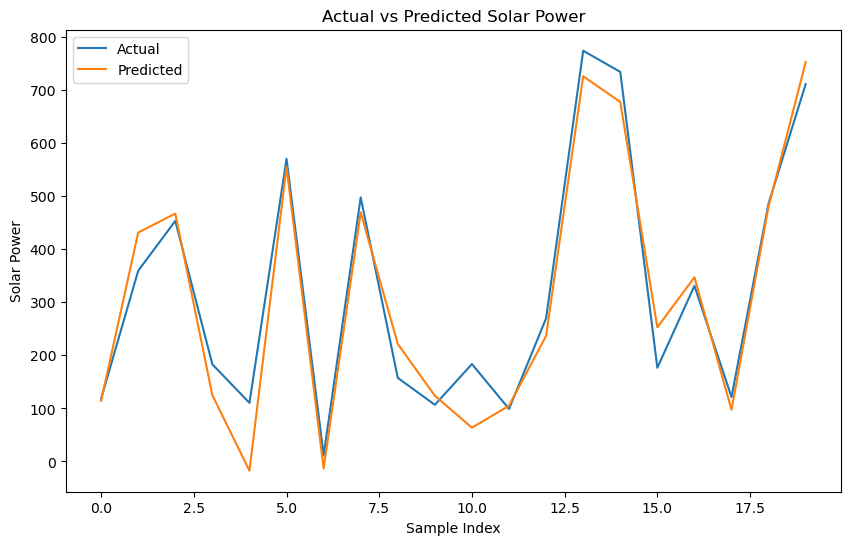

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 生成示例数据
np.random.seed(0)
data_size = 100
solar_irradiance = np.random.rand(data_size) * 1000  # 太阳辐照度 (0-1000 W/m^2)
temperature = np.random.rand(data_size) * 40  # 温度 (0-40 °C)
humidity = np.random.rand(data_size) * 100  # 湿度 (0-100%)

# 假设太阳能发电量与太阳辐照度、温度和湿度有关
solar_power = 0.8 * solar_irradiance + 0.1 * temperature - 0.05 * humidity + np.random.randn(data_size) * 50

# 创建DataFrame
df = pd.DataFrame({
    'solar_irradiance': solar_irradiance,
    'temperature': temperature,
    'humidity': humidity,
    'solar_power': solar_power
})

# 特征和目标变量
X = df[['solar_irradiance', 'temperature', 'humidity']]
y = df['solar_power']

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 创建随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 显示预测结果
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Solar Power')
plt.title('Actual vs Predicted Solar Power')
plt.show()